# Imports

In [2]:
import os
from scipy.io import loadmat
import pandas as pd
from pathlib import Path
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({
    'text.usetex': True,            # Usar LaTeX para todo el texto
    'font.size': 14,                # Tamaño de la fuente general
    'axes.titlesize': 14,           # Tamaño de los títulos de los ejes
    'axes.labelsize': 14,           # Tamaño de las etiquetas de los ejes
    'xtick.labelsize': 14,          # Tamaño de las etiquetas de los ticks del eje x
    'ytick.labelsize': 14,          # Tamaño de las etiquetas de los ticks del eje y
    'legend.fontsize': 14,          # Tamaño de la fuente en las leyendas
    'figure.titlesize': 16,         # Tamaño del título principal de la figura
    'text.latex.preamble': r'\usepackage{amsmath}'  # Permitir usar amsmath en LaTeX
})

def vars_from_dictname(fname):
    cadena = str(fname)
    inicio = cadena.find('S_')
    fin = cadena.rfind('.mat')
    fname = cadena[inicio:fin]

    partes = fname.split('_')
    sk_params = {}

    for i in range(len(partes)):
        if partes[i] == 'm':
            sk_params['M'] = int(partes[i + 1])
        elif partes[i] == 'n':
            sk_params['N'] = int(partes[i + 1])
        elif partes[i] == 'vsc':
            sk_params['n_v_scales'] = int(partes[i + 1])
        elif partes[i] == 'hsc':
            sk_params['n_h_scales'] = int(partes[i + 1])
        elif partes[i] == 'bases':
            sk_params['base_v'] = float(partes[i + 1])
            sk_params['base_h'] = float(partes[i + 2])
        elif partes[i] == 'thV':
            sk_params['n_v_thetas'] = int(partes[i + 1])
        elif partes[i] == 'thH':
            sk_params['n_h_thetas'] = int(partes[i + 1])

    return sk_params


# Función para cargar los archivos .mat y extraer los datos
def load_perform_files_from_folder(main_dir):
    main_dir = Path(main_dir)  # Asegurarse de que sea un objeto Path
    list_perform = []

    for file_path in main_dir.rglob("perform.mat"):  # Buscar recursivamente perform.mat
        try:
            mat_data = loadmat(file_path, squeeze_me=True)
            mat_data_squeezed = {key: value for key, value in mat_data.items() if not key.startswith('__')}

            dic_path = {'source_file': str(file_path)}

            # Extraer parámetros desde dic_name
            dic_name = mat_data_squeezed.get('dic_name', None)
            if dic_name is not None:
                sk_params = vars_from_dictname(dic_name)
                combined_data = {**mat_data_squeezed, **sk_params, **dic_path}
                list_perform.append(combined_data)
        except Exception as e:
            print(f"Error al cargar {file_path}: {e}")

    # Convertir la lista en un DataFrame
    df = pd.DataFrame(list_perform)

    df[['Tstart', 'rm', 'room']] = df['source_file'].str.extract(r'T(\d+)\\rm_([\d.]+)\\([^\\]+)\\')
    # Convertir Tstart y rm a tipos numéricos
    df['Tstart'] = df['Tstart'].astype(int)  # Tstart será un entero
    df['rm'] = df['rm'].astype(float)        # rm será un float

    print(f"Se han cargado {len(list_perform)} archivos 'perform.mat'.")
    return df


def load_results_csv(main_directory):
    """
    Loads all 'results.csv' files from a directory and its subdirectories into a single DataFrame.
    
    Args:
        main_directory (str or Path): Path to the main directory.
    
    Returns:
        pd.DataFrame: A combined DataFrame with data from all 'results.csv' files.
    """
    main_directory = Path(main_directory)  # Ensure it's a Path object
    dfs_list = []  # List to store DataFrames

    # Recursively search for all 'results.csv' files
    for file_path in main_directory.rglob("results.csv"):
        try:
            # Load the file into a DataFrame
            df = pd.read_csv(file_path)

            # Add information from the dictionary
            dic_name = df.iloc[0]['dic_name']
            sk_params = vars_from_dictname(dic_name)  # Dictionary {'M': 128, 'N': 128}
            for key, value in sk_params.items():
                df[key] = value

            # Add a column with the file path (optional, useful for tracking)
            df['source_file'] = str(file_path)
            dfs_list.append(df)

        except Exception as e:
            # Capture and display errors with more details
            print(f"Error processing the file {file_path}: {e}")

    # Combine the DataFrames
    if dfs_list:
        final_df = pd.concat(dfs_list, ignore_index=True)
        print(f"{len(dfs_list)} 'results.csv' files have been loaded.")
        return final_df
    else:
        print("No 'results.csv' files found.")
        return pd.DataFrame()  # Return an empty DataFrame if no files are found





# Best dict for deterministic case:
BS_m_128_n_128_vsc_0_hsc_2_bases_0.1_0.5_thV_15_thH_15.mat 

outputs\det\M128\T0\rm_0.33\Balder\2024-11-20\18-30-06\performance\perform.mat

# Load and save file for deterministic runs

In [24]:

from pathlib import Path
# PATHS of the outputs
path_det_boost = Path(r"outputs/det/M128")
path_det_shear = Path(r"outputs/det/shearlets")
path_det_boostSameScaling = Path(r"outputs/det/M128_same_scaling_fun")
path_det_boostLikeShear = Path(r"outputs/det/sc_like_shearlets")


# LOAD files
df_det_boosts = load_perform_files_from_folder(path_det_boost)
df_det_shears = load_perform_files_from_folder(path_det_shear)
df_det_boostSameScaling = load_perform_files_from_folder(path_det_boostSameScaling)
df_det_boostLikeShear = load_perform_files_from_folder(path_det_boostLikeShear)

# Save files
df_det_boosts.to_json(f'boostlets_deterministic_outputs.json', orient="records", lines=True)
df_det_shears.to_json(f'shearlets_deterministic_outputs.json', orient="records", lines=True)
df_det_boostSameScaling.to_json(f'boostlets_det_Same_Scaling_Function.json', orient="records", lines=True)
df_det_boostLikeShear.to_json(f'boostlets_det_scales_like_Shearlets.json', orient="records", lines=True)


Se han cargado 324 archivos 'perform.mat'.
Se han cargado 4 archivos 'perform.mat'.
Se han cargado 162 archivos 'perform.mat'.
Se han cargado 36 archivos 'perform.mat'.


# Comparison with shearlets

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


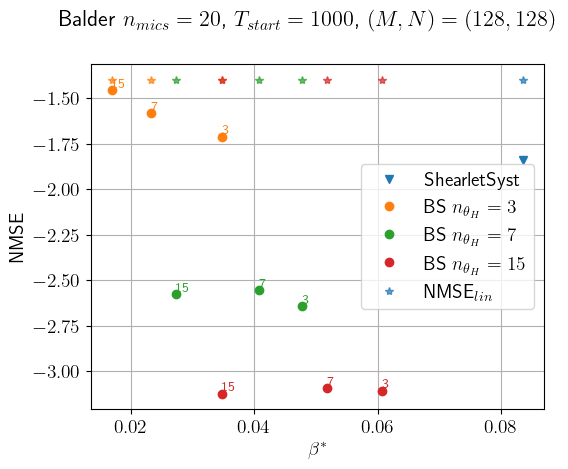

In [30]:
Tstart=1000
ratio_mics=0.2
nmics=int(ratio_mics*100.)
str_title = rf'Balder $n_{{mics}}={nmics}$, $T_{{start}}={Tstart}$, $(M,N)=(128, 128)$'

df = df_det_boostLikeShear[(df_det_boostLikeShear['Tstart']==Tstart) & (df_det_boostLikeShear['rm']==ratio_mics)]
df_ss = df_det_shears[(df_det_shears['Tstart']==Tstart) & (df_det_shears['rm']==ratio_mics)]

ss_df = df_ss[ (df_ss['M']==128) & (df_ss['N']==128) ]
bs_df_a = df[(df['M']==128) & (df['N']==128) & (df['n_v_scales']==3) & (df['n_h_scales']==3) & (df['n_h_thetas']==3)]
bs_df_b = df[(df['M']==128) & (df['N']==128) & (df['n_v_scales']==3) & (df['n_h_scales']==3) & (df['n_h_thetas']==7)]
bs_df_c = df[(df['M']==128) & (df['N']==128) & (df['n_v_scales']==3) & (df['n_h_scales']==3) & (df['n_h_thetas']==15)]

xax = 'beta_star'
yax = 'NMSE'

colors = {
    'shearlets': '#1f77b4',    # Azul para ShearletsSyst
    'bs_df_a': '#ff7f0e',      # Naranja para la primera variación de BS
    'bs_df_b': '#2ca02c',      # Verde para la segunda variación de BS
    'bs_df_c': '#d62728'       # Rojo oscuro para la tercera variación de BS
}

fig, ax = plt.subplots()
ax.plot(ss_df[xax], ss_df[yax], 'v', label='ShearletSyst', color=colors['shearlets'])
ax.plot(bs_df_a[xax], bs_df_a[yax], 'o', label=fr'BS $n_{{\theta_H}} = {bs_df_a["n_h_thetas"].iloc[0]}$', color=colors['bs_df_a'])
ax.plot(bs_df_b[xax], bs_df_b[yax], 'o', label=fr'BS $n_{{\theta_H}} = {bs_df_b["n_h_thetas"].iloc[0]}$', color=colors['bs_df_b'])
ax.plot(bs_df_c[xax], bs_df_c[yax], 'o', label=fr'BS $n_{{\theta_H}} = {bs_df_c["n_h_thetas"].iloc[0]}$', color=colors['bs_df_c'])

# Graficar NMSE_lin
ax.plot(ss_df[xax], ss_df['NMSE_lin'], '*', alpha=0.7, label=r'NMSE$_{lin}$')
ax.plot(bs_df_a[xax], bs_df_a['NMSE_lin'], '*', alpha=0.7)
ax.plot(bs_df_b[xax], bs_df_b['NMSE_lin'], '*', alpha=0.7)
ax.plot(bs_df_c[xax], bs_df_c['NMSE_lin'], '*', alpha=0.7)


# Añadir texto con el valor de 'n_v_thetas' cerca de cada punto en bs_df_a
for i, txt in enumerate(bs_df_a['n_v_thetas']):
    ax.text(bs_df_a[xax].iloc[i], bs_df_a[yax].iloc[i], str(txt), fontsize=10, color=colors['bs_df_a'], ha='left', va='bottom')
    
for i, txt in enumerate(bs_df_b['n_v_thetas']):
    ax.text(bs_df_b[xax].iloc[i], bs_df_b[yax].iloc[i], str(txt), fontsize=10, color=colors['bs_df_b'], ha='left', va='bottom')

for i, txt in enumerate(bs_df_c['n_v_thetas']):
    ax.text(bs_df_c[xax].iloc[i], bs_df_c[yax].iloc[i], str(txt), fontsize=10, color=colors['bs_df_c'], ha='left', va='bottom')

# Etiquetas de los ejes
ax.set_xlabel(r'$\beta^*$')   # Etiqueta con formato LaTeX
ax.set_ylabel('NMSE')
ax.grid(True)

# Mostrar leyenda y gráfica
# plt.legend(loc='lower left', bbox_to_anchor=(0.65, 0.1), fontsize='small', framealpha=0.8)  # Fuera de la gráfica
plt.legend(loc='best')  # Fuera de la gráfica

plt.suptitle(str_title)
plt.tight_layout(rect=(0, 0, 0.9, 1)) # solves a problem where the right part of the plot is missing in .eps
plt.savefig(f'./figs_paper/NMSE_beta_star_ss_bstan_BalderT{Tstart}_m{nmics}_M128.eps', format='eps', bbox_inches='tight')
plt.savefig(f'./figs_paper/NMSE_beta_star_ss_bstan_BalderT{Tstart}_m{nmics}_M128.jpg', format='jpg', bbox_inches='tight')
plt.show()

## Compare for same scaling function size

In [77]:
print(df_det_boostSameScaling['n_h_scales'].unique())
print(df_det_boostSameScaling['n_v_scales'].unique())


[0 1 2]
[0 1 2]


In [76]:
print(df_det_boostSameScaling['Tstart'].unique())
print(df_det_boostSameScaling['rm'].unique())


[   0 1000]
[0.33]


## How to choose good parameters for Boostlets:
- High n_h_thetas (15)
- High n_v_thetas (15)
- Low n_v_scales (0)
- Undetermined/Low n_h_scales

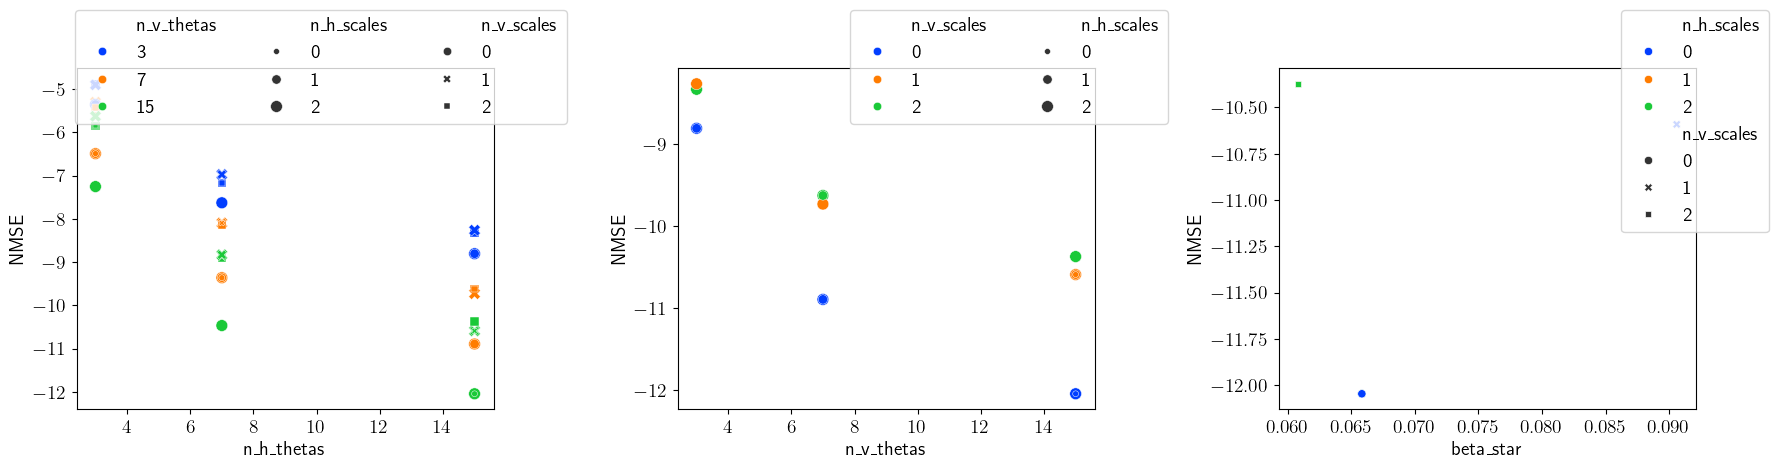

In [84]:


Tstart=0
rm=0.33

df_filter = df_det_boostSameScaling[ (df_det_boostSameScaling['Tstart']==Tstart) & (df_det_boostSameScaling['rm']==rm) ]
fig, axs = plt.subplots(1,3, figsize=(18,5))
sns.scatterplot(data=df_filter,
                x='n_h_thetas',
                y='NMSE',
                hue='n_v_thetas',
                size='n_h_scales',
                style='n_v_scales',
                palette="bright",
                ax=axs[0]
                )
axs[0].legend(loc='upper right', ncol=3, bbox_to_anchor=(1.2, 1.2))

df_filter2 = df_filter[(df_filter['n_h_thetas']==15)]
sns.scatterplot(data=df_filter2,
                x='n_v_thetas',
                y='NMSE',
                hue='n_v_scales',
                size='n_h_scales',
                palette="bright",
                ax=axs[1]
                )
axs[1].legend(loc='upper right', ncol=2, bbox_to_anchor=(1.2, 1.2))

df_filter3 = df_filter2[(df_filter2['n_v_thetas']==15)]
sns.scatterplot(data=df_filter3,
                x='beta_star',
                y='NMSE',
                hue='n_h_scales',
                style='n_v_scales',
                palette="bright",
                ax=axs[2]
                )
axs[2].legend(loc='upper right', ncol=1, bbox_to_anchor=(1.2, 1.2))

plt.tight_layout()

plt.show()


In [85]:
# df_sorted = df_filter3[['NMSE', 'n_v_scales', 'n_h_scales']].sort_values(by='NMSE')
df_sorted = df_filter2[['NMSE', 'n_v_thetas' ,'n_v_scales', 'n_h_scales']].sort_values(by='NMSE')
df_sorted

,NMSE,n_v_thetas,n_v_scales,n_h_scales
48,-12.046932,15,0,0
4,-12.046729,15,0,1
19,-12.046558,15,0,2
57,-10.895490,7,0,2
68,-10.895333,7,0,1
23,-10.893025,7,0,0
47,-10.592146,15,1,1
33,-10.592139,15,1,2
70,-10.591920,15,1,0
37,-10.372949,15,2,0


+ Para T=0
    - n_h_thetas=15 seguro
    - n_v_thetas=15,7,3 el siguiente parametro
    - Luego n_v_scales=0, 1, 2
    - Y luego n_h_scales=0,1,2 (Que no debe influir, los resultados varían mucho menos que el std debido a la mascara)


+ Para T=1000
    - n_h_thetas=15 seguro
    - n_v_scales=2,1,0   (En el rango del std)
    - n_v_thetas=15,7,3  (En el rango del std)
    - Y luego n_h_scales=0,1,2 (Que no debe influir, los resultados varían mucho menos que el std debido a la mascara)


## Check best dicts

In [12]:
 # Check for best dicitonary (deterministic run / same mask and image)
index_min = df_det_boosts['NMSE'].idxmin()
df_det_boosts_optimal = df_det_boosts.loc[index_min, 'dic_name']
print(f"Dictionary with the optimal value : {df_det_boosts_optimal}")
df_det_boosts_optimal = df_det_boosts.loc[index_min, 'source_file']
print(f"Path of the dictionary: {df_det_boosts_optimal}")

df_det_boostsa = df_det_boosts[(df_det_boosts['base_v'] == 0.1) & (df_det_boosts['base_h'] == 0.5) & 
   (df_det_boosts['n_v_thetas'] == 15) & (df_det_boosts['n_h_thetas'] == 15) & 
   (df_det_boosts['room'] == 'Balder') & (df_det_boosts['rm'] == 0.33) &
   (df_det_boosts['Tstart'] == 0)
   ]

df_det_boostsb = df_det_boosts[(df_det_boosts['base_v'] == 0.1) & (df_det_boosts['base_h'] == 0.1) & 
   (df_det_boosts['n_v_thetas'] == 15) & (df_det_boosts['n_h_thetas'] == 15) & 
   (df_det_boosts['room'] == 'Balder') & (df_det_boosts['rm'] == 0.33) &
   (df_det_boosts['Tstart'] == 0)
   ]

print(f"NMSE of best dictionary with alphas=(0.1, 0.5):  {df_det_boostsa['NMSE'].iloc[0]}")
print(f"NMSE of best dictionary with alphas=(0.1, 0.1):  {df_det_boostsb['NMSE'].iloc[0]}")


Dictionary with the optimal value : BS_m_128_n_128_vsc_0_hsc_2_bases_0.1_0.5_thV_15_thH_15.mat
Path of the dictionary: outputs\det\M128\T0\rm_0.33\Balder\2024-11-20\18-30-06\performance\perform.mat
NMSE of best dictionary with alphas=(0.1, 0.5):  -11.894021089071707
NMSE of best dictionary with alphas=(0.1, 0.1):  -11.886815768764428


## Best dict for $T_0=0$, $rm=0.2$

In [23]:
T0 = 0
rm=0.2

df_filt = df_det_boosts[ 
   (df_det_boosts['room'] == 'Balder') & (df_det_boosts['rm'] == rm) &
   (df_det_boosts['Tstart'] == T0)
   ]

indice_min = df_filt['NMSE'].idxmin()
df_optimal = df_filt.loc[indice_min, 'dic_name']
print("----------------------------------------------------------------------------")
print("-------------------------Boostlets------------------------------------------")

print(f"NMSE of best boostlet dictionary for T0={T0}, rm={rm}:  {df_filt['NMSE'].iloc[0]}")
print(f"Path: {df_filt['source_file'].iloc[0]}")
print(f"Name: {df_filt['dic_name'].iloc[0]}")

print("----------------------------------------------------------------------------")
print("-------------------------Shearlets------------------------------------------")

df_filt = df_det_shears[ 
   (df_det_shears['room'] == 'Balder') & (df_det_shears['rm'] == rm) &
   (df_det_shears['Tstart'] == T0)
   ]

print(f"NMSE of best shearlet dictionary for T0={T0}, rm={rm}:  {df_filt['NMSE'].iloc[0]}")
print(f"Path: {df_filt['source_file'].iloc[0]}")
print(f"Name: {df_filt['dic_name'].iloc[0]}")


----------------------------------------------------------------------------
-------------------------Boostlets------------------------------------------
NMSE of best boostlet dictionary for T0=0, rm=0.2:  -4.976760707283615
Path: outputs\det\M128\T0\rm_0.2\Balder\2024-11-20\18-04-33\performance\perform.mat
Name: BS_m_128_n_128_vsc_2_hsc_19_bases_0.5_0.9_thV_7_thH_15.mat
----------------------------------------------------------------------------
-------------------------Shearlets------------------------------------------
NMSE of best shearlet dictionary for T0=0, rm=0.2:  -2.2302618596917116
Path: outputs\det\shearlets\T0\rm_0.2\Balder\2024-11-20\02-41-38\performance\perform.mat
Name: SS_m_128_n_128.mat


# Pareto plot
Plot bstar vs Jcurve
for the case:  
- T0, T1000
- rm = 0.2, 0.33
- rooms = Freja, Balder, Munin
- dicts: shearlets, boostlets

Datos de la simulacion de stats

In [6]:

l_Tstart = [0, 1000]
l_dicts = ['SS_m_128_n_128.mat', 'BS_m_128_n_128_vsc_0_hsc_0_bases_0.1_0.1_thV_15_thH_15.mat']
l_rooms = ['Balder', 'Freja', 'Munin']
l_rm = [0.2, 0.33]


# # LOAD files
path_stat_runs = Path(r"outputs/stats")
df_stats = load_perform_files_from_folder(path_stat_runs)


Se han cargado 720 archivos 'perform.mat'.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


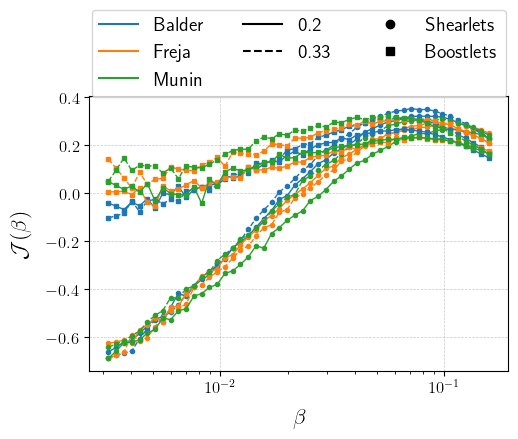

In [7]:
from matplotlib.lines import Line2D

# Datos iniciales
l_Tstart = [0, 1000]
l_dicts = ['SS_m_128_n_128.mat', 'BS_m_128_n_128_vsc_0_hsc_0_bases_0.1_0.1_thV_15_thH_15.mat']
l_dicts_label = ['Shearlets', 'Boostlets']
l_rooms = ['Balder', 'Freja', 'Munin']
l_rm = [0.2, 0.33]

Tstart = l_Tstart[1]

# Preparar estilos visuales
colors = ['tab:blue', 'tab:orange', 'tab:green']  # Diferentes colores por habitación
line_styles = ['-', '--']  # Diferentes estilos por `rm`
markers = ['o', 's']  # Diferentes marcadores por `dic_name`

fig, ax = plt.subplots(figsize=(6, 5))

for j, sk in enumerate(l_dicts):  # Iterar sobre diccionarios
    for k, room in enumerate(l_rooms):  # Iterar sobre habitaciones
        for l, rm in enumerate(l_rm):  # Iterar sobre valores de rm

            # Filtrar datos
            dfi = df_stats[
                (df_stats['Tstart'] == Tstart) &
                (df_stats['dic_name'] == sk) &
                (df_stats['room'] == room) &
                (df_stats['rm'] == rm)
            ]

            # Evitar errores si no hay datos
            if dfi.empty:
                continue
            
            # Restablecer el índice
            dfi = dfi.reset_index(drop=True)
            
            # Obtener datos de la curva
            Jcurve = dfi.loc[0, 'Jcurve']
            beta_set = dfi.loc[0, 'beta_set']
            
            # Estilo según las categorías
            color = colors[k % len(colors)]  # Ciclar colores por habitación
            linestyle = line_styles[l % len(line_styles)]  # Ciclar estilos por rm
            marker = markers[j % len(markers)]  # Ciclar marcadores por diccionario
            
            # Etiqueta legible
            # label = f"{sk.split('.')[0]}, {room}, rm={rm}"
            label = f"{l_dicts_label[j]}, {room}, rm={rm}"

            
            # Graficar
            ax.semilogx(
                beta_set, Jcurve,
                label=label,
                color=color,
                linestyle=linestyle,
                marker=marker,
                linewidth=1,
                markersize=3
            )

# Mejorar apariencia del gráfico
ax.set_xlabel(r'$\beta$', fontsize=16, labelpad=10)
ax.set_ylabel(r'$\mathcal{J}(\beta)$', fontsize=16, labelpad=10)
# ax.set_title('Curvature Function', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Añadir leyenda
# ax.legend(fontsize=10, loc='best')
# ax.legend(fontsize=10, loc='best', handlelength=4, ncol=2)  # handlelength controla la longitud de los símbolos
# ax.legend(
#     fontsize=10, loc='upper center', handlelength=3, ncol=2, 
#     bbox_to_anchor=(0.5, 1.55)  # Centrar arriba, fuera del gráfico
# )

legend_elements = [
    Line2D([0], [0], color=colors[0], linestyle='-', label=l_rooms[0]),
    Line2D([0], [0], color=colors[1], linestyle='-', label=l_rooms[1]),
    Line2D([0], [0], color=colors[2], linestyle='-', label=l_rooms[2]),
    Line2D([0], [0], color='k', linestyle=line_styles[0], label=l_rm[0]),
    Line2D([0], [0], color='k', linestyle=line_styles[1], label=l_rm[1]),
    Line2D([0], [0], color='k', marker=markers[0], linestyle='', label=l_dicts_label[0]),
    Line2D([0], [0], color='k', marker=markers[1], linestyle='', label=l_dicts_label[1]),
]

# Configurar la leyenda personalizada
ax.legend(handles=legend_elements, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.35))


# plt.tight_layout()
plt.tight_layout(rect=(0, 0, 0.9, 1)) # solves a problem where the right part of the plot is missing in .eps
plt.savefig(f'./figs_paper/Pareto_T{Tstart}_J_beta.eps', format='eps', bbox_inches='tight')
plt.savefig(f'./figs_paper/Pareto_T{Tstart}_J_beta.jpg', format='jpg', bbox_inches='tight')
plt.show()


# Load & Plot Boostlets and Shearlets Stats

In [8]:
from pathlib import Path
# PATHS of the outputs
path_boost = Path(r"outputs/stats/M128")
path_shear = Path(r"outputs/stats/shearlets")

# LOAD files
df_boosts = load_perform_files_from_folder(path_boost)
df_shears = load_perform_files_from_folder(path_shear)

df_boosts[['Tstart', 'rm', 'room']] = df_boosts['source_file'].str.extract(r'T(\d+)\\rm_([\d.]+)\\([^\\]+)\\')
df_boosts['Tstart'] = df_boosts['Tstart'].astype(int)  # Tstart será un entero
df_boosts['rm'] = df_boosts['rm'].astype(float)        # rm será un float

df_shears[['Tstart', 'rm', 'room']] = df_shears['source_file'].str.extract(r'T(\d+)\\rm_([\d.]+)\\([^\\]+)\\')
df_shears['Tstart'] = df_shears['Tstart'].astype(int)  # Tstart será un entero
df_shears['rm'] = df_shears['rm'].astype(float)        # rm será un float

# Save files
df_boosts.to_json(f'boostlets_statistics_outputs.json', orient="records", lines=True)
df_shears.to_json(f'shearlets_statistics_outputs.json', orient="records", lines=True)



Se han cargado 360 archivos 'perform.mat'.
Se han cargado 360 archivos 'perform.mat'.


## All in a boxplot

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Supongamos que tienes los DataFrames df_boosts y df_shears con las mismas columnas relevantes
Tstarts = [0, 1000]
indT = 0

custom_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']  # Paleta ampliada

# Agregar una columna para identificar la fuente de los datos
df_boosts['source'] = 'boosts'
df_shears['source'] = 'shears'

# Combinar los DataFrames
df_combined = pd.concat([df_boosts, df_shears])

# Filtrar por Tstart
df_T = df_combined[df_combined['Tstart'] == Tstarts[indT]]

# Crear una nueva columna para combinar 'source' y 'rm' en una categoría única
df_T['source_rm'] = df_T['source'] + ' | ' + df_T['rm'].astype(str)

# Crear subgráficos
fig, axs = plt.subplots(figsize=(12, 6))

# Graficar con seaborn
sns.boxplot(
    data=df_T,
    x="room",
    y="NMSE",
    hue="source_rm",  # Usa la nueva columna combinada como diferenciador
    ax=axs,
    palette=custom_palette
)

# Personalizar la gráfica
axs.set_title(f"Comparación de Boosts y Shears para Tstart = {Tstarts[indT]} por 'rm'")
axs.set_ylabel("NMSE")
axs.set_xlabel("Room")

plt.legend(title="Source | RM", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Boxplot Boostlets vs Shearlets for Tstart, rm

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Tstarts = [0, 1000]

# W=3.6
# plt.rcParams.update({
#     'figure.figsize': (W, W/(4/3)),
#     'text.usetex': True,            # Usar LaTeX para todo el texto
#     'font.size': 10,                # Tamaño de la fuente general
#     'axes.titlesize': 10,           # Tamaño de los títulos de los ejes
#     'axes.labelsize': 10,           # Tamaño de las etiquetas de los ejes
#     'xtick.labelsize': 10,          # Tamaño de las etiquetas de los ticks del eje x
#     'ytick.labelsize': 10,          # Tamaño de las etiquetas de los ticks del eje y
#     'legend.fontsize': 10,          # Tamaño de la fuente en las leyendas
#     'figure.titlesize': 12,         # Tamaño del título principal de la figura
#     'text.latex.preamble': r'\usepackage{amsmath}'  # Permitir usar amsmath en LaTeX
# })

W=5.8
plt.rcParams.update({
    'figure.figsize': (W, W/(4/3)),
    'text.usetex': True,            # Usar LaTeX para todo el texto
    'font.size': 20,                # Tamaño de la fuente general
    'axes.titlesize': 20,           # Tamaño de los títulos de los ejes
    'axes.labelsize': 20,           # Tamaño de las etiquetas de los ejes
    'xtick.labelsize': 20,          # Tamaño de las etiquetas de los ticks del eje x
    'ytick.labelsize': 20,          # Tamaño de las etiquetas de los ticks del eje y
    'legend.fontsize': 20,          # Tamaño de la fuente en las leyendas
    'figure.titlesize': 22,         # Tamaño del título principal de la figura
    'text.latex.preamble': r'\usepackage{amsmath}'  # Permitir usar amsmath en LaTeX
})


figs_outputs_stats = "./figs_paper/NMSEstats"

l_Tstart = [0, 1000]
l_dicts = ['SS_m_128_n_128.mat', 'BS_m_128_n_128_vsc_0_hsc_0_bases_0.1_0.1_thV_15_thH_15.mat']
l_dicts_label = ['Shearlets', 'Boostlets']
l_rooms = ['Balder', 'Freja', 'Munin']
l_rm = [0.2, 0.33]

custom_palette = ['#1f77b4', '#ff7f0e']  # Azul para Boostlet, Naranja para Shearlet


idT = 0 
id_rm = 0 

# Filtros
for idT in [0,1]:
    for id_rm in [0,1]: 


        # Filtrar los DataFrames por Tstart y rm
        df_boosts_filtered = df_boosts[(df_boosts['Tstart'] == l_Tstart[idT]) & (df_boosts['rm'] == l_rm[id_rm])].copy()
        df_shears_filtered = df_shears[(df_shears['Tstart'] == l_Tstart[idT]) & (df_shears['rm'] == l_rm[id_rm])].copy()
        # Agregar una columna para identificar el tipo
        df_boosts_filtered['Type'] = 'Boostlets'
        df_shears_filtered['Type'] = 'Shearlets'
        # Combinar los DataFrames
        df_combined = pd.concat([df_boosts_filtered, df_shears_filtered])

        # Crear el gráfico
        # fig, axs = plt.subplots(figsize=(5, 4))
        fig, axs = plt.subplots()
        sns.boxplot(
            data=df_combined,
            x="room",
            y="NMSE",
            hue="Type",  # Diferenciador entre Boostlet y Shearlet
            ax=axs,
            palette=custom_palette
        )

        # Personalizar el gráfico
        axs.set_title(f"$\\text{{T}}_0={Tstarts[idT]}$ \n $\\text{{r.m.}}={l_rm[id_rm]}$", loc='left' )
        axs.set_ylabel("$\\text{NMSE}$")
        axs.set_xlabel("")
        axs.grid(True)
        plt.legend(loc='center right', bbox_to_anchor=(1., 1.2))
        plt.tight_layout(rect=(0, 0, 0.9, 1)) # solves a problem where the right part of the plot is missing in .eps
        plt.savefig(f'{figs_outputs_stats}/BSvsSS_T{Tstarts[idT]}_rm_{l_rm[id_rm]}.jpg', format='jpg', bbox_inches='tight')
        plt.savefig(f'{figs_outputs_stats}/BSvsSS_T{Tstarts[idT]}_rm_{l_rm[id_rm]}.eps', format='eps', bbox_inches='tight')
        plt.show()


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Tstarts = [0, 1000]

# W=3.6
# plt.rcParams.update({
#     'figure.figsize': (W, W/(4/3)),
#     'text.usetex': True,            # Usar LaTeX para todo el texto
#     'font.size': 10,                # Tamaño de la fuente general
#     'axes.titlesize': 10,           # Tamaño de los títulos de los ejes
#     'axes.labelsize': 10,           # Tamaño de las etiquetas de los ejes
#     'xtick.labelsize': 10,          # Tamaño de las etiquetas de los ticks del eje x
#     'ytick.labelsize': 10,          # Tamaño de las etiquetas de los ticks del eje y
#     'legend.fontsize': 10,          # Tamaño de la fuente en las leyendas
#     'figure.titlesize': 12,         # Tamaño del título principal de la figura
#     'text.latex.preamble': r'\usepackage{amsmath}'  # Permitir usar amsmath en LaTeX
# })

W=5.8
plt.rcParams.update({
    'figure.figsize': (W, W/(4/3)),
    'text.usetex': True,            # Usar LaTeX para todo el texto
    'font.size': 20,                # Tamaño de la fuente general
    'axes.titlesize': 20,           # Tamaño de los títulos de los ejes
    'axes.labelsize': 20,           # Tamaño de las etiquetas de los ejes
    'xtick.labelsize': 20,          # Tamaño de las etiquetas de los ticks del eje x
    'ytick.labelsize': 20,          # Tamaño de las etiquetas de los ticks del eje y
    'legend.fontsize': 20,          # Tamaño de la fuente en las leyendas
    'figure.titlesize': 22,         # Tamaño del título principal de la figura
    'text.latex.preamble': r'\usepackage{amsmath}'  # Permitir usar amsmath en LaTeX
})


figs_outputs_stats = "./figs_paper/NMSEstats"

l_Tstart = [0, 1000]
l_dicts = ['SS_m_128_n_128.mat', 'BS_m_128_n_128_vsc_0_hsc_0_bases_0.1_0.1_thV_15_thH_15.mat']
l_dicts_label = ['Shearlets', 'Boostlets']
l_rooms = ['Balder', 'Freja', 'Munin']
l_rm = [0.2, 0.33]

custom_palette = ['#1f77b4', '#ff7f0e']  # Azul para Boostlet, Naranja para Shearlet


idT = 0 
id_rm = 0 

# Filtros
for idT in [0,1]:
    for id_rm in [0,1]: 


        # Filtrar los DataFrames por Tstart y rm
        df_boosts_filtered = df_boosts[(df_boosts['Tstart'] == l_Tstart[idT]) & (df_boosts['rm'] == l_rm[id_rm])].copy()
        df_shears_filtered = df_shears[(df_shears['Tstart'] == l_Tstart[idT]) & (df_shears['rm'] == l_rm[id_rm])].copy()
        # Agregar una columna para identificar el tipo
        df_boosts_filtered['Type'] = 'Boostlets'
        df_shears_filtered['Type'] = 'Shearlets'
        # Combinar los DataFrames
        df_combined = pd.concat([df_boosts_filtered, df_shears_filtered])

        # Crear el gráfico
        # fig, axs = plt.subplots(figsize=(5, 4))
        fig, axs = plt.subplots()
        sns.boxplot(
            data=df_combined,
            x="room",
            y="NMSE",
            hue="Type",  # Diferenciador entre Boostlet y Shearlet
            ax=axs,
            palette=custom_palette
        )

        # Personalizar el gráfico
        axs.set_title(f"$\\text{{T}}_0={Tstarts[idT]}$,  $\\text{{r.m.}}={l_rm[id_rm]}$", loc='center' )
        axs.set_ylabel("$\\text{NMSE}$")
        axs.set_xlabel("")
        axs.grid(True)
        # plt.legend(loc='center right', bbox_to_anchor=(1., 1.2))
        axs.legend_.remove()
        plt.tight_layout(rect=(0, 0, 0.9, 1)) # solves a problem where the right part of the plot is missing in .eps
        plt.savefig(f'{figs_outputs_stats}/BSvsSS_T{Tstarts[idT]}_rm_{l_rm[id_rm]}.jpg', format='jpg', bbox_inches='tight')
        plt.savefig(f'{figs_outputs_stats}/BSvsSS_T{Tstarts[idT]}_rm_{l_rm[id_rm]}.eps', format='eps', bbox_inches='tight')
        plt.show()


# MAC

In [ ]:
sns.set_theme(style="darkgrid")

idT=1
id_rm=1

for idT in [0,1]:
     for id_rm in [0,1]:

        df_boosts['Type'] = 'Boostlets'
        df_shears['Type'] = 'Shearlets'
        df_combined = pd.concat([df_boosts, df_shears])

        # Seleccionar solo las columnas relevantes.
        #                     x        y              colors        lineStyle
        # df_selection = df[['frqMAC', 'MAC', 'Tstart', 'room', 'rm', 'Type']] 
        # df_selection = df_combined[['frqMAC', 'MAC', 'Tstart', 'room', 'rm', 'Type']] 
        # # Filtrar para T0 y rm
        # df_T_rm = df_selection[(df_selection['Tstart'] == l_Tstart[idT]) & (df_selection['rm'] == l_rm[id_rm]) ] 

        # 1. Filter by Tstart and rm
        df_filtered = df_combined[(df_combined['Tstart'] == l_Tstart[idT]) & (df_combined['rm'] == l_rm[id_rm]) ] 
        # 2. Choose only dimensions to plot
        df_selection = df_filtered[['frqMAC', 'MAC', 'room', 'Type']]

        # 3. Convert DataFrame into a long structure
        expanded_data = []
        for idx, row in df_selection.iterrows():
            x_values = row['frqMAC']
            y_values = row['MAC']
            for x, y in zip(x_values, y_values):
                expanded_data.append({'frqMAC': x, 'MAC': y, 'room': row['room'], 'Type': row['Type']})

        long_df = pd.DataFrame(expanded_data)

        # 4. Plot
        sns.lineplot(
            data=long_df,
            x='frqMAC', 
            y='MAC', 
            hue='room',        # Diferenciar por colores
            style='Type',         # Diferenciar por estilos de línea
            # size='importance',     # Diferenciar por grosor de línea
            # palette='tab10',       # Paleta de colores
            # sizes=(0.5, 2.5)       # Rango de grosor de las líneas
            errorbar='sd', 
            estimator='mean',
        )

        plt.xlabel('$f(Hz)$')
        plt.ylabel('$C(f)$')
        plt.title(f"$\\text{{T}}_0={Tstarts[idT]}$,  $\\text{{r.m.}}={l_rm[id_rm]}$", loc='center' )
        plt.tight_layout(rect=(0, 0, 0.9, 1)) # solves a problem where the right part of the plot is missing in .eps
        plt.savefig(f'{figs_outputs_stats}/MAC_{Tstarts[idT]}_rm_{l_rm[id_rm]}.jpg', format='jpg', bbox_inches='tight')
        plt.savefig(f'{figs_outputs_stats}/MAC_{Tstarts[idT]}_rm_{l_rm[id_rm]}.eps', format='eps', bbox_inches='tight')
        plt.show()